In [7]:
import numpy as np
import re
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dot, Dense, Flatten
from tensorflow.keras.optimizers import Adam

def load_and_preprocess_data(file_path):
    text = io.open(file_path, encoding='UTF-8').read().lower()
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\d', '', text)  
    text = re.sub(r'\s+', ' ', text)  
    return text

text = load_and_preprocess_data('/content/advs.txt')

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])
sequences = [item for sublist in sequences for item in sublist]  
vocab_size = len(tokenizer.word_index) + 1

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dot, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

vocab_size = len(tokenizer.word_index) + 1 
embedding_dim = 100

t
input_target = Input(shape=(1,), name='target_input')
input_context = Input(shape=(1,), name='context_input')

target_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='target_embedding')(input_target)
target_embedding = Flatten(name='flatten_target')(target_embedding)

context_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='context_embedding')(input_context)
context_embedding = Flatten(name='flatten_context')(context_embedding)

dot_product = Dot(axes=-1, name='dot_product')([target_embedding, context_embedding])
output = Dense(1, activation='sigmoid', name='output')(dot_product)

model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_input (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 context_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 target_embedding (Embeddin  (None, 1, 100)               833900    ['target_input[0][0]']        
 g)                                                                                               
                                                                                                  
 context_embedding (Embeddi  (None, 1, 100)               833900    ['context_input[0][0]']   

In [4]:
pairs, labels = skipgrams(sequences, vocabulary_size=vocab_size, window_size=4, negative_samples=4.0, shuffle=True)
pairs, labels = np.array(pairs), np.array(labels)

In [ ]:
model.fit([pairs[:, 0], pairs[:, 1]], labels, batch_size=1024, epochs=10)

Epoch 1/10
4080/4080 [==============================] - 98s 23ms/step - loss: 0.2706 - accuracy: 0.9091
Epoch 2/10
4080/4080 [==============================] - 126s 31ms/step - loss: 0.2288 - accuracy: 0.9172
Epoch 3/10
4080/4080 [==============================] - 93s 23ms/step - loss: 0.2118 - accuracy: 0.9211
Epoch 4/10
4080/4080 [==============================] - 92s 23ms/step - loss: 0.1901 - accuracy: 0.9261
Epoch 5/10
4080/4080 [==============================] - 87s 21ms/step - loss: 0.1688 - accuracy: 0.9320
Epoch 6/10
4080/4080 [==============================] - 92s 22ms/step - loss: 0.1537 - accuracy: 0.9375
Epoch 7/10
4080/4080 [==============================] - 90s 22ms/step - loss: 0.1447 - accuracy: 0.9409
Epoch 8/10
4080/4080 [==============================] - 90s 22ms/step - loss: 0.1395 - accuracy: 0.9429
Epoch 9/10
4080/4080 [==============================] - 92s 23ms/step - loss: 0.1363 - accuracy: 0.9440
Epoch 10/10
2585/4080 [==================>...........] - ETA: 3

In [8]:
target_embeddings = model.get_layer('target_embedding').get_weights()[0]
context_embeddings = model.get_layer('context_embedding').get_weights()[0]

final_word_embeddings = target_embeddings + context_embeddings

word = 'queen'
word_idx = tokenizer.word_index[word]  
final_embedding_vector = final_word_embeddings[word_idx] 

print(f"Final embedding for '{word}': {final_embedding_vector[:10]}")

Final embedding for 'queen': [ 0.10652524  0.7392317  -0.56955934  0.2885857  -0.3367176   0.24935484
 -0.3921674  -0.1898902  -0.81169575 -0.24792132]


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def get_final_embedding(word, word_embeddings, word_index):
    idx = word_index.get(word)
    if idx is not None:
        return word_embeddings[idx]
    else:
        return np.zeros((word_embeddings.shape[1],))

king_vector = get_final_embedding('king', final_word_embeddings, tokenizer.word_index)
man_vector = get_final_embedding('man', final_word_embeddings, tokenizer.word_index)
woman_vector = get_final_embedding('woman', final_word_embeddings, tokenizer.word_index)
queen_vector = get_final_embedding('queen', final_word_embeddings, tokenizer.word_index)

result_vector = king_vector - man_vector + woman_vector

queen_vector = queen_vector.reshape(1, -1)
result_vector = result_vector.reshape(1, -1)

similarity = cosine_similarity(queen_vector, result_vector)

print(f"Similarity between 'queen' and 'king - man + woman': {similarity[0][0]}")


Similarity between 'queen' and 'king - man + woman': 0.3834049701690674


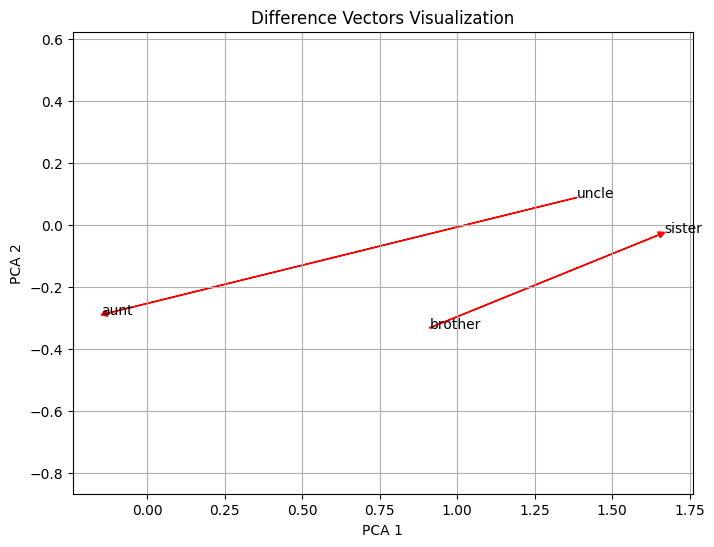

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
word_embeddings_2d = pca.fit_transform(final_word_embeddings)


def get_word_vector_2d(word):
    idx = tokenizer.word_index[word]
    return word_embeddings_2d[idx]

def plot_difference_vectors(word_pairs):
    plt.figure(figsize=(8, 6))

    for word1, word2 in word_pairs:
        vec1 = get_word_vector_2d(word1)
        vec2 = get_word_vector_2d(word2)
        diff = vec2 - vec1

        plt.arrow(vec1[0], vec1[1], diff[0], diff[1], head_width=0.02, head_length=0.02, length_includes_head=True, color='red')
        plt.text(vec1[0], vec1[1], word1)
        plt.text(vec2[0], vec2[1], word2)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Difference Vectors Visualization')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

word_pairs = [('brother', 'sister'), ('uncle', 'aunt')]
plot_difference_vectors(word_pairs)

